In [4]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import wave
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, filtfilt, lfilter
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

## Import Data

In [2]:
def load_audio_from_folder(folder_path, label):
    audio_data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'): 
            full_path = os.path.join(folder_path, filename)
            try:
                signal, sr = librosa.load(full_path, sr=None)  # sr=None untuk mempertahankan frekuensi asli
                duration = len(signal) / sr
                audio_data.append({
                    'filename': full_path,
                    'signal': signal,
                    'sampling_rate': sr,
                    'duration': duration,
                    'label': label  # Menambahkan label untuk setiap kategori
                })
            except Exception as e:
                print(f"Error reading {full_path}: {e}")

    return audio_data

artifact_path = 'Heartbeat_Sound/artifact'
artifact_audio = load_audio_from_folder(artifact_path, 'artifact')
df_artifact = pd.DataFrame(artifact_audio)

extrahls_path = 'Heartbeat_Sound/extrahls'
extrahls_audio = load_audio_from_folder(extrahls_path, 'extrahls')
df_extrahls = pd.DataFrame(extrahls_audio)

extrastole_path = 'Heartbeat_Sound/extrastole'
extrastole_audio = load_audio_from_folder(extrastole_path, 'extrastole')
df_extrastole = pd.DataFrame(extrastole_audio)

murmur_path = 'Heartbeat_Sound/murmur'
murmur_audio = load_audio_from_folder(murmur_path, 'murmur')
df_murmur = pd.DataFrame(murmur_audio)

normal_path = 'Heartbeat_Sound/normal'
normal_audio = load_audio_from_folder(normal_path, 'normal')
df_normal = pd.DataFrame(normal_audio)

df = pd.concat([df_artifact,df_murmur, df_normal, df_extrastole, df_extrahls], ignore_index=True)

In [3]:
df['label'].value_counts()

label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64

## Preprocessing

In [4]:
df

,filename,signal,sampling_rate,duration,label
0,Heartbeat_Sound/artifact\artifact__20101217201...,"[3.0517578e-05, -9.1552734e-05, -3.0517578e-05...",44100,9.000000,artifact
1,Heartbeat_Sound/artifact\artifact__20110504091...,"[-6.1035156e-05, 9.1552734e-05, -0.00012207031...",44100,9.000000,artifact
2,Heartbeat_Sound/artifact\artifact__20110504195...,"[0.00018310547, -0.00012207031, -0.0002746582,...",44100,9.000000,artifact
3,Heartbeat_Sound/artifact\artifact__20110505101...,"[-0.0025939941, -0.0060424805, -0.0065307617, ...",44100,9.000000,artifact
4,Heartbeat_Sound/artifact\artifact__20110506010...,"[0.0016174316, -0.0010681152, 0.0014343262, 0....",44100,9.000000,artifact
...,...,...,...,...,...
580,Heartbeat_Sound/extrahls\extrahls__20110320021...,"[0.010040283, 0.009857178, 0.010345459, 0.0101...",44100,9.000000,extrahls
581,Heartbeat_Sound/extrahls\extrahls__20110402135...,"[-0.00079345703, -0.00088500977, -0.0010681152...",44100,0.936372,extrahls
582,Heartbeat_Sound/extrahls\extrahls__20110414011...,"[0.00030517578, -3.0517578e-05, -0.00012207031...",44100,1.947392,extrahls
583,Heartbeat_Sound/extrahls\extrahls__20110427045...,"[-0.03036499, -0.028900146, -0.028198242, -0.0...",44100,3.235397,extrahls


In [5]:
def normalize_audio(signal):
    """Normalizes the audio signal to the range [-1, 1]."""
    return signal / np.max(np.abs(signal))

def band_pass_filter(signal, lowcut, highcut, fs, order=5):
    """Applies a band-pass filter to the audio signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def clip_or_pad(signal, target_samples):
    """Clips or pads the audio signal to the target length."""
    if len(signal) < target_samples:
        signal = np.pad(signal, (0, target_samples - len(signal)), 'constant')
    else:
        signal = signal[:target_samples]
    return signal  # Return the processed signal

def preprocess(row, target_duration):
    """Processes a single row of the DataFrame."""
    signal = row['signal']
    sr = row['sampling_rate']
    target_samples = int(target_duration * sr)
    
    normalized_signal = normalize_audio(signal)
    
    processed_signal = clip_or_pad(normalized_signal, target_samples)
    
    # Adjust the band-pass filter frequencies according to the characteristics of your data
    filtered_signal = band_pass_filter(processed_signal, lowcut=100, highcut=1500, fs=sr)
    
    return filtered_signal

# Define target duration for padding/clipping
target_duration = 6  # in seconds
df['processed_signal'] = df.apply(lambda row: preprocess(row, target_duration), axis=1)

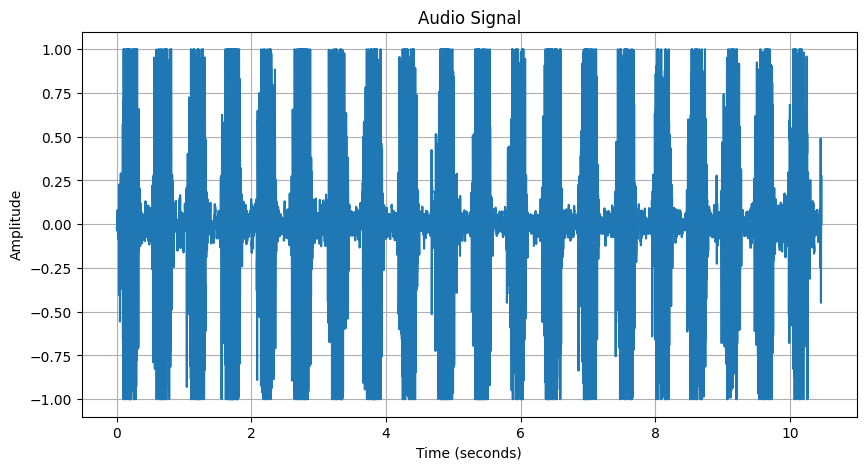

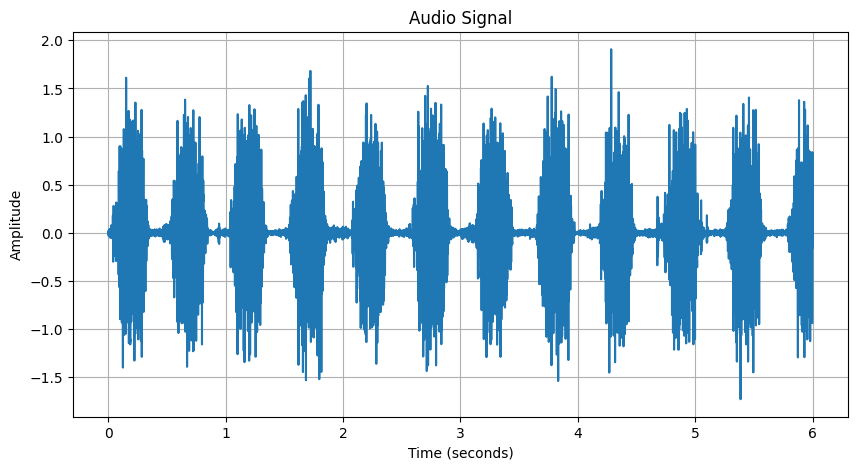

In [6]:
def plot_signal(signal, fs):
    """Plot the audio signal."""
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 5))
    plt.plot(time, signal)
    plt.title('Audio Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

fs = 4000  # Sampling rate
plot_signal(df['signal'][100], fs)
plot_signal(df['processed_signal'][100], fs)

## Feature Extraction

In [7]:
def extract_features(signal, sr):
    # Menghitung rata-rata interval detak
    intervals = np.diff(np.where(signal > 0)[0]) / sr
    mean_interval = np.mean(intervals) if len(intervals) > 0 else np.nan

    # Menghitung HRV (SDNN dan RMSSD)
    sdnn = np.std(intervals) if len(intervals) > 0 else np.nan
    rmssd = np.sqrt(np.mean(np.square(np.diff(intervals)))) if len(intervals) > 1 else np.nan

    # Menghitung FFT dan puncak frekuensi
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    fft_values = np.abs(np.fft.rfft(signal))
    peak_freq = freqs[np.argmax(fft_values)] if len(fft_values) > 0 else np.nan

    # Menghitung energi
    energy = np.sum(signal**2)

    # Menghitung MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)

    # Zero-crossing rate
    zero_crossings = librosa.feature.zero_crossing_rate(signal)[0]
    zero_crossing_rate = np.mean(zero_crossings)

    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)[0]
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # RMS Energy
    rms = librosa.feature.rms(y=signal)[0]
    rms_mean = np.mean(rms)

    return {
        'mean_interval': mean_interval,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'peak_freq': peak_freq,
        'energy': energy,
        'mfcc_mean': mfcc_mean,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'chroma_mean': chroma_mean,
        'rms_mean': rms_mean
    }


def process_feature_extract(df):
    all_features = []

    for index, row in df.iterrows():
        signal = row['processed_signal']
        sr = row['sampling_rate']
        
        features = extract_features(signal, sr)
        features['filename'] = row['filename']
        
        all_features.append(features)

    return pd.DataFrame(all_features)

features_df = process_feature_extract(df)

## Modeling (ANN)

In [8]:
features_df

,mean_interval,sdnn,rmssd,peak_freq,energy,mfcc_mean,zero_crossing_rate,spectral_centroid_mean,spectral_bandwidth_mean,chroma_mean,rms_mean,filename
0,0.000045,0.000170,0.000243,181.666667,145.288924,"[-576.5830033241881, 42.4807548287202, 22.0072...",0.030981,785.068608,555.881113,"[0.57921060788811, 0.549457317666276, 0.561733...",0.004324,Heartbeat_Sound/artifact\artifact__20101217201...
1,0.000045,0.000129,0.000185,211.166667,148.151620,"[-591.0930282083615, 72.61962264099854, 10.406...",0.041962,958.109446,622.322985,"[0.5942578927973968, 0.60906584669927, 0.61672...",0.009696,Heartbeat_Sound/artifact\artifact__20110504091...
2,0.000046,0.000132,0.000189,463.666667,177.689774,"[-472.5488412621986, 233.50278592498535, 23.65...",0.039681,922.469841,553.807820,"[0.5898594115607603, 0.6718455575767824, 0.607...",0.016369,Heartbeat_Sound/artifact\artifact__20110504195...
3,0.000045,0.000172,0.000246,467.500000,73.003435,"[-496.0363088234935, 222.8071052952423, 57.081...",0.022709,655.737940,464.209141,"[0.48849284425059963, 0.454278458842367, 0.474...",0.013869,Heartbeat_Sound/artifact\artifact__20110505101...
4,0.000045,0.000167,0.000238,173.666667,471.737747,"[-422.2670699562918, 165.601640650228, 51.4227...",0.027088,718.736199,507.577118,"[0.5678437042125806, 0.6021268103545843, 0.573...",0.020556,Heartbeat_Sound/artifact\artifact__20110506010...
...,...,...,...,...,...,...,...,...,...,...,...,...
580,0.000045,0.000251,0.000356,157.666667,571.346081,"[-464.654203839591, 147.97844904086145, 83.096...",0.010387,352.039087,331.003965,"[0.5107219814775679, 0.5073032661892926, 0.575...",0.030011,Heartbeat_Sound/extrahls\extrahls__20110320021...
581,0.000045,0.000346,0.000490,140.666667,469.081364,"[-525.7345286312446, 29.562147165581923, 12.51...",0.001953,134.915686,105.125088,"[0.30482202364203453, 0.26155219623483267, 0.2...",0.012792,Heartbeat_Sound/extrahls\extrahls__20110402135...
582,0.000046,0.000313,0.000444,134.500000,437.619915,"[-498.8124558770372, 43.070962223648756, 18.85...",0.006469,253.138227,202.071390,"[0.4311472972659982, 0.3855219863644064, 0.363...",0.011572,Heartbeat_Sound/extrahls\extrahls__20110414011...
583,0.000045,0.000297,0.000422,139.500000,1626.122994,"[-453.421365235846, 82.63927915462787, 45.0337...",0.004742,220.749034,201.202505,"[0.5123252384168187, 0.4769548801374296, 0.487...",0.042396,Heartbeat_Sound/extrahls\extrahls__20110427045...


In [9]:
# Assuming 'features_df' and 'label' column already exist and preprocessing is done
mfcc_flattened = np.array(features_df['mfcc_mean'].tolist())
chroma_flattened = np.array(features_df['chroma_mean'].tolist())

# Concatenate all numerical features
X = np.hstack((
    features_df[['mean_interval', 'sdnn', 'rmssd', 'peak_freq', 'energy',
                 'zero_crossing_rate', 'spectral_centroid_mean',
                 'spectral_bandwidth_mean', 'rms_mean']].values,
    mfcc_flattened, chroma_flattened
))

In [11]:
# Encode the label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # Make sure you use 'df'

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

# One-hot encode the labels
num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train = np.expand_dims(x_train, axis=1)
x_val = np.expand_dims(x_val, axis=1)
x_test = np.expand_dims(x_test, axis=1)

In [14]:
x_train

array([[[5.00897779e-04, 9.69384910e-04, 1.40724967e-03, ...,
         4.67387520e-01, 3.42947927e-01, 2.96769017e-01]],

       [[5.04691181e-04, 7.78384185e-04, 1.14716024e-03, ...,
         6.69509077e-01, 6.81238269e-01, 6.56645940e-01]],

       [[5.00981293e-04, 9.75182739e-04, 1.41791464e-03, ...,
         7.07728099e-01, 4.72132137e-01, 3.67788957e-01]],

       ...,

       [[5.01987448e-04, 9.30504218e-04, 1.35110215e-03, ...,
         6.58463070e-01, 5.08253426e-01, 4.46123197e-01]],

       [[4.60771282e-05, 3.02649222e-04, 4.29289842e-04, ...,
         6.11899299e-01, 6.11101399e-01, 6.29493240e-01]],

       [[4.56050122e-05, 2.14111563e-04, 3.04420913e-04, ...,
         6.55558222e-01, 6.62197267e-01, 6.92127160e-01]]])

In [15]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1082 - loss: 2.4508 - val_accuracy: 0.4574 - val_loss: 1.5299
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2604 - loss: 1.9428 - val_accuracy: 0.5106 - val_loss: 1.4101
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3540 - loss: 1.8260 - val_accuracy: 0.5426 - val_loss: 1.3122
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4029 - loss: 1.5750 - val_accuracy: 0.5957 - val_loss: 1.2433
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5308 - loss: 1.3922 - val_accuracy: 0.5957 - val_loss: 1.1915
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5535 - loss: 1.2917 - val_accuracy: 0.6064 - val_loss: 1.1414
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5960 - loss: 1.2533 - val_accuracy: 0.5957 - val_loss: 1.1068
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5909 - loss: 1.2195 - val_accuracy: 0.6064 - 

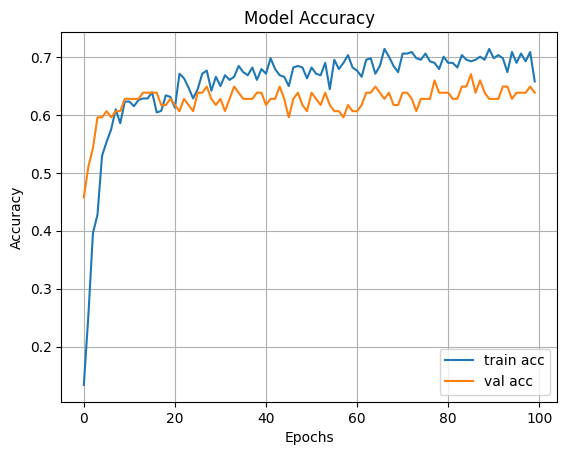

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Predict class probabilities
y_pred_probs = model.predict(x_test)

# Convert to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
              precision    recall  f1-score   support

    artifact       1.00      0.75      0.86         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.00      0.00      0.00         9
      murmur       0.56      0.35      0.43        26
      normal       0.71      0.96      0.82        70

    accuracy                           0.70       117
   macro avg       0.46      0.41      0.42       117
weighted avg       0.62      0.70      0.64       117



## Testing

In [18]:
def preprocess_and_extract_features_from_file(file_path, target_duration=6):
    try:
        signal, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None

    # Normalize
    normalized_signal = normalize_audio(signal)

    # Pad or clip
    target_samples = int(target_duration * sr)
    processed_signal = clip_or_pad(normalized_signal, target_samples)

    # Band-pass filter
    filtered_signal = band_pass_filter(processed_signal, lowcut=100, highcut=1500, fs=sr)

    # Extract features
    features = extract_features(filtered_signal, sr)

    # Flatten MFCC and Chroma
    mfcc_flat = features['mfcc_mean']
    chroma_flat = features['chroma_mean']

    # Combine features into a single vector
    feature_vector = np.hstack((
        np.array([
            features['mean_interval'], features['sdnn'], features['rmssd'],
            features['peak_freq'], features['energy'],
            features['zero_crossing_rate'], features['spectral_centroid_mean'],
            features['spectral_bandwidth_mean'], features['rms_mean']
        ]),
        mfcc_flat,
        chroma_flat
    ))

    return feature_vector.reshape(1, -1)  # Reshape for model prediction

In [21]:
def predict_heartbeat_class(file_path):
    features = preprocess_and_extract_features_from_file(file_path)
    
    if features is None:
        print("Feature extraction failed.")
        return

    # Reshape for LSTM (samples, timesteps=1, features)
    features = np.expand_dims(features, axis=1)

    # Predict
    prediction_probs = model.predict(features)
    predicted_class_index = np.argmax(prediction_probs)
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
    
    print(f"Predicted class: {predicted_class_label}")
    print(f"Class probabilities: {prediction_probs}")

In [22]:
test_file_path = 'Heartbeat_Sound/extrahls/extrahls__201104270459.wav'  # Replace with actual path
predict_heartbeat_class(test_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class: murmur
Class probabilities: [[1.7109698e-02 1.7456345e-01 6.4567622e-04 7.0055121e-01 1.0713006e-01]]
